In [12]:
# Importação das bibliotecas necessárias
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, MultiHeadAttention, LayerNormalization, Layer, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences




In [13]:
class TransformerLayer(Layer):
    def __init__(self, num_heads, hidden_size, dropout_rate):
        super(TransformerLayer, self).__init__()
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=hidden_size)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.layer_norm = LayerNormalization()

    def call(self, inputs):
        attention_output = self.attention(inputs, inputs)
        attention_output = self.dropout(attention_output)
        attention_output = self.layer_norm(attention_output + inputs)
        return attention_output

In [14]:
import requests
url = 'https://fiapdatasets.blob.core.windows.net/deeplearning/morte_vida_severina.txt'


response = requests.get(url)
file_Path = 'morte_vida_severina.txt'

if response.status_code == 200:
    with open(file_Path, 'wb') as file:
        file.write(response.content)
    print('Download com Sucesso')
else:
    print('Falha no Download')

Download com Sucesso


In [15]:
# Carregar o texto do arquivo e transformar tudo para minúsculas para manter uniformidade
with open("morte_vida_severina.txt", "r", encoding='utf-8') as file:
    text = file.read().lower()
print(text)

— o meu nome é severino,
como não tenho outro de pia.
como há muitos severinos,
que é santo de romaria,
deram então de me chamar
severino de maria;
como há muitos severinos
com mães chamadas maria,
fiquei sendo o da maria
do finado zacarias.
mais isso ainda diz pouco:
há muitos na freguesia,
por causa de um coronel
que se chamou zacarias
e que foi o mais antigo
senhor desta sesmaria.
como então dizer quem falo
ora a vossas senhorias?
vejamos: é o severino
da maria do zacarias,
lá da serra da costela,
limites da paraíba.
mas isso ainda diz pouco:
se ao menos mais cinco havia
com nome de severino
filhos de tantas marias
mulheres de outros tantos,
já finados, zacarias,
vivendo na mesma serra
magra e ossuda em que eu vivia.
somos muitos severinos
iguais em tudo na vida:
na mesma cabeça grande
que a custo é que se equilibra,
no mesmo ventre crescido
sobre as mesmas pernas finas
e iguais também porque o sangue,
que usamos tem pouca tinta.
e se somos severinos
iguais em tudo na vida,
morremos

In [16]:
# Etapa 1: Tokenização
# Cria um Tokenizer para converter palavras em números, pois o modelo precisa de entradas numéricas
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])  # Adapta o tokenizer ao texto fornecido
total_words = len(tokenizer.word_index) + 1  # Contagem de palavras distintas (vocabulário)
print(total_words)

1538


In [17]:
# Mapeamento índice -> palavra
index_to_word = {index: word for word, index in tokenizer.word_index.items()}
print("Índice para Palavra:", index_to_word)

Índice para Palavra: {1: 'que', 2: 'de', 3: '—', 4: 'a', 5: 'o', 6: 'e', 7: 'é', 8: 'não', 9: 'se', 10: 'da', 11: 'mais', 12: 'em', 13: 'vida', 14: 'para', 15: 'como', 16: 'na', 17: 'do', 18: 'mas', 19: 'terra', 20: 'das', 21: 'me', 22: 'com', 23: 'almas', 24: 'os', 25: 'no', 26: 'aqui', 27: 'por', 28: 'dos', 29: 'um', 30: 'uma', 31: 'te', 32: 'há', 33: 'minha', 34: 'sua', 35: 'as', 36: 'morte', 37: 'gente', 38: 'onde', 39: 'foi', 40: 'ao', 41: 'também', 42: 'severino', 43: 'melhor', 44: 'ou', 45: 'agora', 46: 'bem', 47: 'quando', 48: 'diga', 49: 'ainda', 50: 'sempre', 51: 'irmãos', 52: 'nem', 53: 'seu', 54: 'lá', 55: 'já', 56: 'eu', 57: 'tem', 58: 'irmão', 59: 'só', 60: 'sei', 61: 'mar', 62: 'retirante', 63: 'rio', 64: 'coisa', 65: 'pouco', 66: 'dia', 67: 'ele', 68: 'água', 69: 'menos', 70: 'mesmo', 71: 'tal', 72: 'vejo', 73: 'será', 74: 'chão', 75: 'belo', 76: 'quem', 77: 'grande', 78: 'até', 79: 'essa', 80: 'tão', 81: 'sabe', 82: 'tua', 83: 'dizer', 84: 'tudo', 85: 'este', 86: 'são'

In [18]:
# Etapa 2: Criação de Sequências
# Constrói sequências para o treinamento do modelo usando o texto original
input_sequences = []
for line in text.split("\n"):  # Divide o texto em linhas
    token_list = tokenizer.texts_to_sequences([line])[0]  # Converte palavras em índices numéricos
    for i in range(1, len(token_list)):  # Cria n-gramas para capturar dependências sequenciais
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)  # Adiciona cada sequência à lista de entradas

# Imprime último n_gram_sequence
print(n_gram_sequence)


[2, 30, 13, 123]


O comando pad_sequences recebe uma lista de listas (onde cada sublista é uma sequência de tokens) e preenche essas listas para que todas tenham o mesmo comprimento. Ele faz isso adicionando um valor especificado (por padrão, 0) no início ou no fim de cada sequência.

Parâmetro padding

Um dos parâmetros principais é padding, que define onde o preenchimento (ou padding) ocorrerá na sequência. Ele pode ter dois valores:
 * padding='pre': Adiciona o padding no início da sequência. Esse é o comportamento padrão.
 * padding='post': Adiciona o padding no final da sequência.


In [19]:
# Etapa 3: Padding e Criação dos rótulos (y)
# Ajusta todas as sequências para um comprimento fixo
max_sequence_len = max([len(x) for x in input_sequences])  # Encontra a sequência mais longa
print(max_sequence_len)
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

10


In [20]:
input_sequences[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 3, 5], dtype=int32)

In [21]:
# Separa os dados em X (entrada) e y (saída)
X, y = input_sequences[:,:-1], input_sequences[:,-1]  # Última palavra de cada sequência será a etiqueta
y = to_categorical(y, num_classes=total_words)  # Converte y para one-hot encoding

print(X[100])
print(y[100])
print(y.shape)

[  0   0   0   0   0   0 585   6 586]
[0. 0. 0. ... 0. 0. 0.]
(4590, 1538)


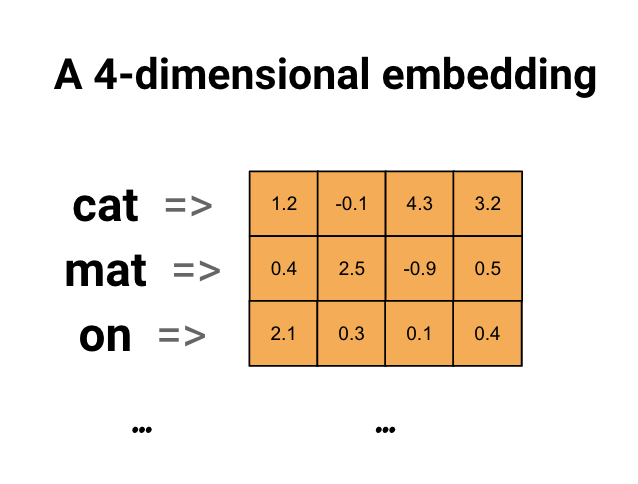

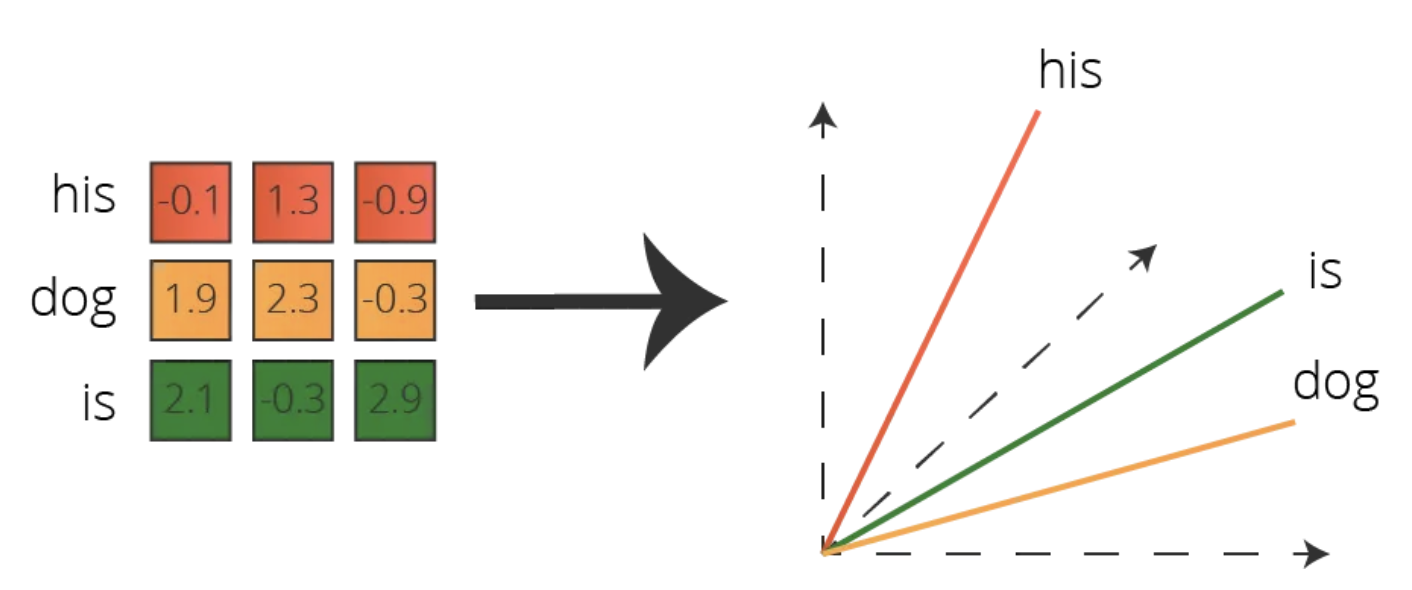

In [22]:
# Etapa 4: Construção do Modelo
# Define o modelo Tranformer com camadas para gerar texto
model = Sequential()
# Camada Embedding para mapear palavras para vetores
model.add(Embedding(input_dim=total_words, output_dim=32, input_length=max_sequence_len - 1))
model.add(TransformerLayer(num_heads=8, hidden_size=64, dropout_rate=0.1))
model.add(Flatten())
model.add(Dense(total_words , activation='softmax'))

# Compilação do modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [23]:
# Treinamento do modelo
model.fit(X, y, epochs=50, verbose=1, batch_size =8)  # Treina por 50 épocas

Epoch 1/50
574/574 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.0249 - loss: 6.9263
Epoch 2/50
574/574 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.0674 - loss: 6.0594
Epoch 3/50
574/574 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1746 - loss: 4.9150
Epoch 4/50
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3384 - loss: 3.6023
Epoch 5/50
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4920 - loss: 2.5527
Epoch 6/50
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5966 - loss: 1.8969
Epoch 7/50
574/574 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6565 - loss: 1.5438
Epoch 8/50
574/574 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6861 - loss: 1.3879
Epoch 9/50
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7013 - loss: 1.2602
Epoch 10/50
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7140 - loss: 1.1799
Epoch 11/50
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7228 - loss: 1.1538
Epoch 12/50
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/ste

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 9, 32)          │        49,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_layer               │ (None, 9, 32)          │        67,168 │
│ (TransformerLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1538)           │       444,482 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,682,600 (6.42 MB)

 Trainable params: 560,866 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,121,734 (4.28 MB)

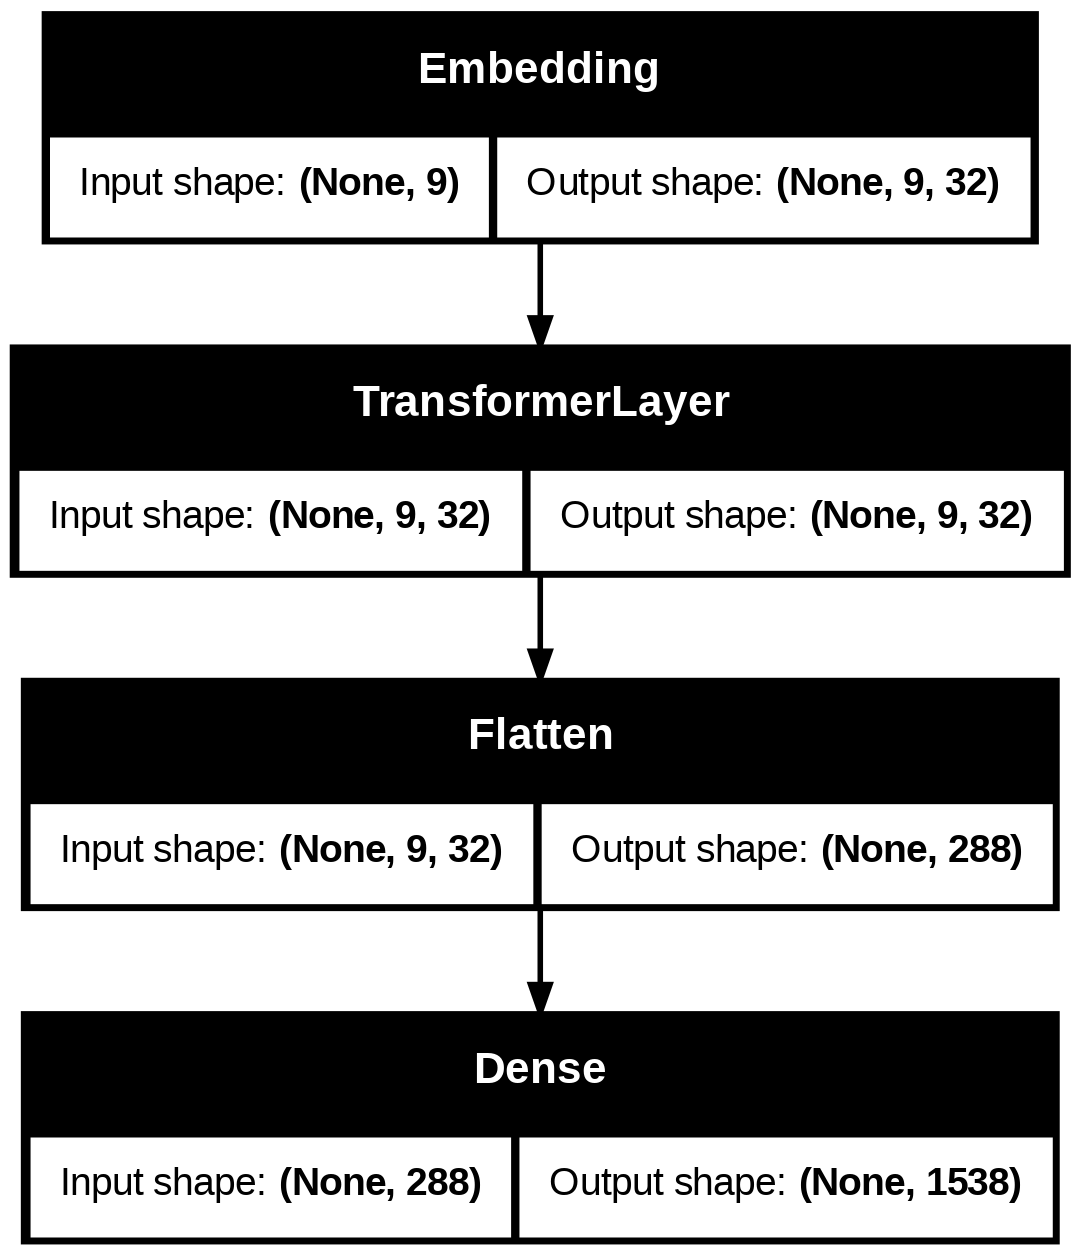

In [25]:
plot_model(model, show_shapes=True)

In [26]:
def gerar_texto(model, tokenizer, seed_text, max_sequence_len, next_words=50):
    """
    Gera texto com um modelo LSTM baseado em seed_text.

    Parâmetros:
    - model: o modelo LSTM treinado.
    - tokenizer: o tokenizer usado para indexar palavras.
    - seed_text: string inicial para começar a geração.
    - max_sequence_len: número máximo de palavras que o modelo aceita.
    - next_words: número de palavras a serem geradas.

    Retorna:
    - Texto gerado como string.
    """
    for _ in range(next_words):
        # Converte o seed_text para uma sequência numérica
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        #print(token_list)
        # Limita o token_list ao tamanho máximo especificado
        token_list = token_list[-(max_sequence_len - 1):]
        #print(token_list)
        # Realiza padding para que o token_list tenha o comprimento correto
        token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
        print(token_list)
        # Faz a previsão da próxima palavra
        predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)

        # Converte o índice previsto de volta para uma palavra
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        # Adiciona a palavra prevista ao seed_text
        seed_text += " " + output_word

    return seed_text

In [27]:
seed_text = "talvez"
texto_gerado = gerar_texto(model, tokenizer, seed_text, max_sequence_len = 10, next_words=6)
print(texto_gerado)

[[   0    0    0    0    0    0    0    0 1478]]
[[   0    0    0    0    0    0    0 1478   78]]
[[   0    0    0    0    0    0 1478   78  105]]
[[   0    0    0    0    0 1478   78  105 1479]]
[[   0    0    0    0 1478   78  105 1479   68]]
[[   0    0    0 1478   78  105 1479   68 1366]]
talvez até lhe conquiste água cobertor gorjetas


In [28]:
seed_text = "é difícil"
texto_gerado = gerar_texto(model, tokenizer, seed_text, max_sequence_len = 10, next_words=6)
print(texto_gerado)

[[  0   0   0   0   0   0   0   7 203]]
[[  0   0   0   0   0   0   7 203 487]]
[[  0   0   0   0   0   7 203 487   1]]
[[  0   0   0   0   7 203 487   1 920]]
[[  0   0   0   7 203 487   1 920  12]]
[[   0    0    7  203  487    1  920   12 1382]]
é difícil defender que querias em paudalho longa


In [29]:
seed_text = "morte"
texto_gerado = gerar_texto(model, tokenizer, seed_text, max_sequence_len =10, next_words=10)
print(texto_gerado)

[[ 0  0  0  0  0  0  0  0 36]]
[[ 0  0  0  0  0  0  0 36  4]]
[[ 0  0  0  0  0  0 36  4  1]]
[[ 0  0  0  0  0 36  4  1  9]]
[[  0   0   0   0  36   4   1   9 422]]
[[  0   0   0  36   4   1   9 422   8]]
[[  0   0  36   4   1   9 422   8 446]]
[[  0  36   4   1   9 422   8 446 240]]
[[ 36   4   1   9 422   8 446 240  31]]
[[  4   1   9 422   8 446 240  31  68]]
morte a que se decida não pude presente te água esperar


In [30]:
seed_text = "mas diga me"
texto_gerado = gerar_texto(model, tokenizer, seed_text, max_sequence_len = 10, next_words=10)
print(texto_gerado)

[[ 0  0  0  0  0  0 18 48 21]]
[[ 0  0  0  0  0 18 48 21 62]]
[[  0   0   0   0  18  48  21  62 149]]
[[  0   0   0  18  48  21  62 149 847]]
[[   0    0   18   48   21   62  149  847 1247]]
[[   0   18   48   21   62  149  847 1247   11]]
[[  18   48   21   62  149  847 1247   11 1501]]
[[  48   21   62  149  847 1247   11 1501  722]]
[[  21   62  149  847 1247   11 1501  722   10]]
[[  62  149  847 1247   11 1501  722   10  723]]
mas diga me retirante compadre azar funda mais palmatória virgem da conceição não


In [31]:
seed_text = "pouco"
texto_gerado = gerar_texto(model, tokenizer, seed_text, max_sequence_len =10, next_words=5)
print(texto_gerado)

[[ 0  0  0  0  0  0  0  0 65]]
[[  0   0   0   0   0   0   0  65 427]]
[[  0   0   0   0   0   0  65 427   5]]
[[  0   0   0   0   0  65 427   5   1]]
[[  0   0   0   0  65 427   5   1 770]]
pouco existe o que lavrar fazia


In [32]:
seed_text = "ao menos"
texto_gerado = gerar_texto(model, tokenizer, seed_text, max_sequence_len=10, next_words=7)
print(texto_gerado)

[[ 0  0  0  0  0  0  0 40 69]]
[[ 0  0  0  0  0  0 40 69 78]]
[[ 0  0  0  0  0 40 69 78  1]]
[[ 0  0  0  0 40 69 78  1 35]]
[[  0   0   0  40  69  78   1  35 415]]
[[  0   0  40  69  78   1  35 415 263]]
[[  0  40  69  78   1  35 415 263 168]]
ao menos até que as águas morrida dá amaro


In [33]:
seed_text = "em vossa"
texto_gerado = gerar_texto(model, tokenizer, seed_text, max_sequence_len = 10, next_words=4)
print(texto_gerado)

[[  0   0   0   0   0   0   0  12 260]]
[[   0    0    0    0    0    0   12  260 1317]]
[[   0    0    0    0    0   12  260 1317 1318]]
[[   0    0    0    0   12  260 1317 1318 1448]]
em vossa prosa entretida lixo triste


In [34]:
seed_text = "pescados"
texto_gerado = gerar_texto(model, tokenizer, seed_text, max_sequence_len =10, next_words=3)
print(texto_gerado)

[[   0    0    0    0    0    0    0    0 1357]]
[[   0    0    0    0    0    0    0 1357   27]]
[[   0    0    0    0    0    0 1357   27  298]]
pescados por esses mangues


In [35]:
seed_text = "há"
texto_gerado = gerar_texto(model, tokenizer, seed_text, max_sequence_len =10, next_words=5)
print(texto_gerado)

[[ 0  0  0  0  0  0  0  0 32]]
[[  0   0   0   0   0   0   0  32 684]]
[[  0   0   0   0   0   0  32 684 392]]
[[  0   0   0   0   0  32 684 392 685]]
[[  0   0   0   0  32 684 392 685 468]]
há certas paragens brancas mundo caçar


In [36]:
seed_text = "mas isso"
texto_gerado = gerar_texto(model, tokenizer, seed_text, max_sequence_len =10, next_words=7)
print(texto_gerado)

[[  0   0   0   0   0   0   0  18 121]]
[[  0   0   0   0   0   0  18 121  49]]
[[  0   0   0   0   0  18 121  49 244]]
[[  0   0   0   0  18 121  49 244  65]]
[[  0   0   0  18 121  49 244  65 426]]
[[  0   0  18 121  49 244  65 426 710]]
[[   0   18  121   49  244   65  426  710 1105]]
mas isso ainda diz pouco adianta cantoria diaristas lavrar
